# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure OpenAI Configuration
AOAI_ENDPOINT=your_azure_openai_endpoint
AOAI_KEY=your_azure_openai_api_key
AOAI_API_VERSION=2024-02-01  # Optional, defaults to this value

# Model Deployment Names
reasoningModel=your_reasoning_model_deployment_name  # e.g., o1-preview
chatModel=your_chat_model_deployment_name  # e.g., gpt-4o

# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Bing Search Agent (pre-created in Azure AI Foundry)
bingSearchAgentID=your_bing_search_agent_id
BING_CONNECTION_NAME=your_bing_connection_name  # Only needed if creating agent inline
```

**Note:** This notebook creates agents inline using the OpenAI Agents SDK, except for the Bing Search agent which must be pre-created in Azure AI Foundry. If you haven't created the Bing Search agent yet, uncomment and run the agent creation cell below.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating the Bing Search Agent (One-time Setup)

The following cell will **create** an **Azure AI Agent** with Bing Search capabilities. You only need to run this cell **once** to create the agent, then save its ID to your `.env` file as `bingSearchAgentID`.

If you already have a Bing Search agent created, skip this cell and use the next cell to update its instructions instead.

In [5]:
# from azure.ai.agents.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
# You are a helpful research assistant.

# Today's date is {current_date}.

# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results.
#     """.strip()
# )

### Updating Existing Bing Search Agent

If you already have a Bing Search agent (with its ID in your `.env` file), run this cell to update its instructions with today's date. This ensures the agent has current date awareness for time-sensitive queries.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-12-10.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


### Creating OpenAI Agents

The following agents are created inline using the OpenAI Agents SDK. These agents handle planning, summarization, research synthesis, and peer review. They are created fresh each time you run the notebook.

In [7]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)


**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

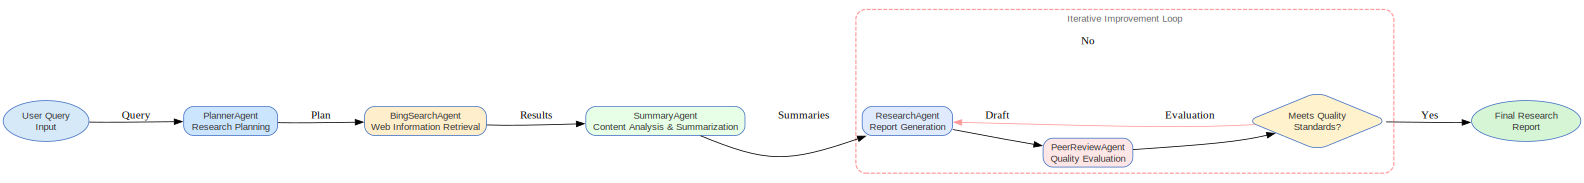

In [9]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in AI',
 'What is generative AI and how does it work?',
 'Differences between classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [13]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 6/6 [06:16<00:00, 62.82s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 24

Actually total search queries: 24



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [15]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics:   0%|          | 0/6 [00:00<?, ?it/s]

Summarizing subtopics: 100%|██████████| 6/6 [02:45<00:00, 27.64s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [16]:
plan.final_output

ResearchPlan(query='What are the differences between classical machine learning, deep learning and generative AI?', objective='To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their definitions, methodologies, applications, strengths, limitations, and interrelationships.', success_criteria=['Clear definitions and distinctions between classical machine learning, deep learning, and generative AI are provided.', 'Key methodologies and algorithms for each approach are identified and explained.', 'Comparative analysis of applications, strengths, and limitations is completed for all three approaches.', 'Interrelationships and overlaps between the approaches are described.', 'Examples and case studies illustrating each approach are included.'], related_topics=['Supervised vs. unsupervised learning', 'Neural network architectures', 'Ethical considerations in AI'], research_tasks=[ResearchTask(id=None, subtopic='Definitions and Co

In [17]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [18]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [19]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI

## Introduction

The field of artificial intelligence (AI) has undergone rapid and transformative evolution over the past several decades, progressing from foundational statistical methods to advanced neural architectures capable of creative synthesis. This report provides an exceptionally comprehensive analysis of classical machine learning (ML), deep learning (DL), and generative AI (GenAI), focusing on their definitions, methodologies, applications, strengths, limitations, and interrelationships. By synthesizing extensive research and case studies, this report aims to clarify the distinctions and overlaps among these paradigms, offering a nuanced perspective on their roles in contemporary AI and their impact across industries.

## Definitions and Core Concepts

### Classical Machine Learning

Classical machine learning represents the foundational layer within the AI hierarchy, defined by its reliance on statistical algorithms and manual feature engineering. The core principle of classical ML is to enable computers to learn patterns and relationships from structured data, typically in the form of tabular datasets. Key paradigms include supervised learning, where models are trained on labeled data to predict outcomes or classify inputs; unsupervised learning, which seeks to uncover hidden structures in unlabeled data through clustering or dimensionality reduction; and reinforcement learning, where agents learn optimal behaviors through reward-based interactions with an environment [1], [2].

Manual feature engineering is a hallmark of classical ML, requiring domain expertise to select and preprocess input features that optimize model performance. This approach is effective for well-defined problems with clear features and smaller datasets, offering advantages in simplicity, lower computational cost, and ease of implementation. However, classical ML faces limitations in adaptability, scalability, and performance when confronted with unstructured or highly complex datasets, and may struggle with tasks requiring nuanced pattern recognition beyond the scope of engineered features [3], [4].

Central concepts in classical ML include overfitting—where models memorize noise in training data rather than generalizing to unseen data—and the bias-variance trade-off, which involves balancing model complexity to avoid underfitting and overfitting. Rigorous model evaluation using metrics such as accuracy, precision, recall, and cross-validation is essential to ensure robust and generalizable solutions [5].

### Deep Learning

Deep learning marks a paradigm shift within machine learning, utilizing artificial neural networks with multiple interconnected layers to automatically learn hierarchical representations from raw data. Inspired by the structure and function of the human brain, deep learning models—including convolutional neural networks (CNNs) for image data, recurrent neural networks (RNNs) for sequential data, and transformer architectures for language—eliminate much of the need for manual feature engineering. These models extract increasingly abstract features through successive layers, enabling the handling of vast, unstructured datasets such as images, audio, and text [6], [7].

Deep learning requires substantial computational resources (GPUs/TPUs) and large volumes of training data, but it has driven state-of-the-art advances in computer vision, speech recognition, natural language processing, and autonomous systems. Training methodologies in deep learning span supervised, semi-supervised, and unsupervised approaches, further expanding the versatility of these models [8], [9].

### Generative AI

Generative AI builds on deep learning foundations to move beyond analysis and prediction, focusing instead on the creation of new, original content. Generative AI systems are trained on massive datasets to learn the underlying patterns and structures, enabling them to generate text, images, music, code, and more in response to user prompts. Core generative models include Generative Adversarial Networks (GANs), which pit two neural networks against each other to produce realistic outputs; Variational Autoencoders (VAEs), which encode and decode data to create new variations; and large language models (LLMs) based on transformer architectures, such as GPT [10], [11].

The concept of "foundation models" refers to these large-scale, pre-trained deep learning models that serve as the basis for diverse generative AI applications. Generative AI distinguishes itself through its ability to recognize and encode complex patterns, generate outputs that often rival human creativity, and adapt across industries—from content creation and code generation to drug discovery and personalized recommendations [12].

### Hierarchical Relationship

The hierarchy of these technologies is clear: artificial intelligence is the broadest field, encompassing machine learning as a subset, with deep learning as a further specialized subset of ML, and generative AI representing a cutting-edge frontier within deep learning focused on creative synthesis [13], [14].

#### Table 1: Hierarchical Breakdown of AI Paradigms

| Layer                | Description                                                      | Data Type        | Feature Engineering    |
|----------------------|------------------------------------------------------------------|------------------|-----------------------|
| Artificial Intelligence | All computational methods simulating human intelligence         | All              | Varies                |
| Machine Learning     | Algorithms learning from data to predict or classify              | Structured       | Manual                |
| Deep Learning        | Neural networks learning hierarchical features                    | Unstructured     | Automatic             |
| Generative AI        | Deep models generating novel content                             | Unstructured     | Automatic             |

## Key Methodologies and Algorithms

### Classical Machine Learning Algorithms

Classical machine learning algorithms form the bedrock of AI, focusing on pattern recognition and predictive modeling. Linear regression, one of the simplest and most interpretable algorithms, uses the least squares method to fit a line to data, excelling in continuous outcome prediction for applications like price forecasting and trend analysis. Logistic regression extends this paradigm to binary classification, employing a sigmoid function to output probabilities, making it suitable for tasks such as spam detection and customer churn prediction [15].

Decision trees introduce non-linearity by segmenting data based on feature-based rules, providing high interpretability but suffering from instability and overfitting, especially with small changes in data. Random forests mitigate these issues by aggregating multiple decision trees in an ensemble, enhancing accuracy and robustness to overfitting, though at the cost of interpretability and increased computational resources. Support Vector Machines (SVMs) leverage geometric principles to find optimal hyperplanes for class separation, particularly effective in high-dimensional spaces but computationally intensive and sensitive to parameter tuning [16], [17].

Other classical algorithms include k-Nearest Neighbors (k-NN), which classifies data points based on proximity in feature space and is effective for small datasets but scales poorly; Naive Bayes, a probabilistic classifier assuming feature independence, which is fast and efficient for high-dimensional data but limited by its independence assumption; Principal Component Analysis (PCA), a linear dimensionality reduction technique aiding visualization and noise reduction; and clustering algorithms like k-Means, which group data based on similarity but require pre-specifying the number of clusters and are sensitive to initialization [18].

### Deep Learning Architectures

Deep learning transcends classical ML by utilizing multi-layered artificial neural networks capable of modeling complex, non-linear relationships in massive datasets. Convolutional Neural Networks (CNNs) are specialized for grid-like data (e.g., images), employing convolutional layers to learn spatial hierarchies and excelling in computer vision tasks such as image classification and object detection. Recurrent Neural Networks (RNNs), and their advanced variant Long Short-Term Memory (LSTM) networks, are tailored for sequential data, capturing temporal dependencies critical for time series analysis and natural language processing [19], [20].

Transformers represent a paradigm shift in deep learning, particularly for natural language processing (NLP). Their self-attention mechanism allows for parallel processing of entire sequences, facilitating state-of-the-art performance in machine translation, text generation, and powering large language models (LLMs) like GPT and BERT. Transformers are increasingly being adapted for vision and multimodal tasks, further broadening their applicability [21].

Generative Adversarial Networks (GANs) introduce adversarial optimization, where a generator and discriminator compete to produce highly realistic synthetic data, revolutionizing image synthesis, data augmentation, and creative applications. Autoencoders and Variational Autoencoders (VAEs) focus on efficient data representation and generative modeling, with VAEs employing probabilistic techniques for latent space exploration and smooth interpolation. Graph Neural Networks (GNNs) extend deep learning to graph-structured data, enabling node classification and link prediction in domains such as social networks and molecular biology. Capsule Networks aim to model hierarchical feature relationships, improving robustness to spatial transformations in vision tasks [22].

Emerging architectures like Mamba State Space Models (SSMs) and Joint Embedding Predictive Architectures (JEPA) push the boundaries of efficiency and scalability, particularly for large-scale and multimodal tasks [23].

### Generative AI Methodologies

Generative AI leverages deep learning to create new data, rather than merely analyzing or classifying existing information. GANs remain central, though they face challenges such as training instability and mode collapse. VAEs offer probabilistic generative modeling, encoding data into latent spaces and reconstructing it with diversity. Diffusion models, a recent breakthrough, generate data by iteratively transforming noise into structured outputs, achieving state-of-the-art results in image generation. Transformer-based architectures, especially LLMs like GPT, Claude, Gemini, and LLaMA, utilize self-attention for flexible sequence modeling, enabling sophisticated text generation and multimodal capabilities [24].

Key algorithms in generative AI include probabilistic modeling (learning data distributions for sampling new instances), latent space exploration (sampling and interpolating in lower-dimensional representations), adversarial optimization (as in GANs), and reinforcement learning from human feedback (RLHF) for fine-tuning model alignment. These methodologies underpin applications ranging from image and video synthesis, data augmentation, and anomaly detection to creative domains like art, music, and automated content generation [25].

#### Table 2: Comparative Summary of Key Algorithms

| Paradigm      | Key Algorithms/Architectures                      | Data Type         | Feature Engineering |
|---------------|---------------------------------------------------|-------------------|--------------------|
| Classical ML  | Linear/Logistic Regression, Decision Trees, SVMs  | Structured        | Manual             |
| Deep Learning | CNNs, RNNs/LSTMs, Transformers, GANs, VAEs        | Unstructured      | Automatic          |
| Generative AI | GANs, VAEs, Diffusion Models, LLMs                | Unstructured      | Automatic          |

## Applications and Use Cases

### Classical Machine Learning

Classical machine learning remains foundational in sectors where structured data and model interpretability are paramount. In manufacturing, ML models are deployed for predictive maintenance by analyzing sensor and equipment data to forecast failures, thereby minimizing downtime and maintenance costs. Quality control benefits from ML-powered image recognition and statistical analysis to detect product defects, while supply chain optimization leverages ML for inventory management, demand forecasting, and process optimization [26].

In finance and banking, classical ML algorithms such as decision trees and logistic regression are central to fraud detection, credit scoring, and risk assessment, providing transparent and auditable decision-making frameworks that align with regulatory demands. Healthcare applications include disease prediction and diagnosis through classification of medical images and patient data, patient monitoring via analysis of vital signs, and accelerating drug discovery by mining chemical and biological datasets [27].

Retail and marketing sectors utilize ML for recommendation engines, customer segmentation, and sales forecasting based on historical and behavioral data. Logistics and transportation benefit from ML-driven route optimization and demand forecasting, while the energy sector employs ML for load forecasting and fault detection in grid management. Cybersecurity relies on ML for anomaly detection in network traffic and user behavior, identifying threats and breaches efficiently [28].

### Deep Learning

Deep learning has expanded the frontiers of AI by enabling machines to learn from vast, complex, and unstructured datasets. In healthcare, deep learning—particularly CNNs—outperforms human experts in medical imaging analysis, detecting tumors and abnormalities in X-rays and MRIs. Early disease detection and personalized medicine are facilitated by analyzing biomarkers and genetic data, while patient risk assessment models improve outcomes and resource allocation [29].

Autonomous systems, including self-driving cars and drones, rely on deep learning for perception, decision-making, and control, interpreting sensor data and navigating dynamic environments. Computer vision applications encompass object detection, tracking, biometric authentication, and artwork identification, with models capable of real-time analysis and classification. NLP tasks such as virtual assistants, chatbots, real-time translation, sentiment analysis, and text summarization are powered by deep neural networks, enabling sophisticated language understanding and generation [30].

In finance and cybersecurity, deep learning models provide real-time fraud detection, customer profiling, and automated investment strategies. Agriculture benefits from environmental monitoring and predictive analytics, while entertainment and media industries utilize deep learning for automatic image and video tagging, photo restoration, and content categorization. Additional applications include spam filtering, handwriting recognition, and game playing at superhuman levels using deep reinforcement learning [31].

### Generative AI

Generative AI represents a transformative leap, enabling the creation of new content—text, images, audio, video, and code—by learning patterns from extensive datasets. In healthcare, generative AI is used for personalized treatment plans, synthetic data generation for privacy-preserving research, and disease detection through image analysis. Financial institutions employ generative AI to create synthetic transaction data for enhanced fraud detection and risk analysis, while entertainment and media industries leverage AI-powered tools for graphic design, video generation, and lifelike audio synthesis [32].

Marketing and advertising benefit from generative AI’s ability to produce personalized ad copy and campaign visuals, with chatbots and virtual assistants enhancing customer engagement. In software development, tools like GitHub Copilot automate code generation and quality assurance, streamlining development cycles. Manufacturing and supply chain management utilize generative AI for design prototyping and logistics optimization through simulation. Education and training are transformed by AI-generated learning materials and virtual tutors, while general business functions see automation in document drafting, HR processes, and meeting summarization [33].

Popular generative AI tools include ChatGPT, Google Bard, Claude (text), DALL·E and Midjourney (images), ElevenLabs and Descript (audio), and GitHub Copilot (code). The impact of generative AI is evident in improved productivity, creativity, and cost reductions, though careful oversight is required to manage potential biases, inaccuracies, and resource demands [34].

#### Table 3: Impact Assessment Matrix Across Industries

| Industry         | Classical ML       | Deep Learning         | Generative AI           |
|------------------|-------------------|-----------------------|-------------------------|
| Healthcare       | Disease prediction | Medical imaging, EHR  | Synthetic data, diagnosis|
| Finance          | Fraud detection    | Real-time profiling   | Synthetic transactions  |
| Manufacturing    | Predictive maintenance | Quality control    | Design prototyping      |
| Retail/Marketing | Recommendation engines | Sentiment analysis | Ad copy, campaign visuals|
| Media/Entertainment | Content categorization | Image/video tagging | Graphic design, video generation|
| Education        | Student assessment | Automated grading     | Learning materials, tutors|

## Strengths and Limitations

### Classical Machine Learning

Classical machine learning is characterized by its ability to automate repetitive tasks, such as sorting emails or detecting spam, which significantly boosts productivity and operational efficiency. Its algorithms are adept at rapidly analyzing large volumes of structured data to deliver actionable insights, thereby enhancing decision-making in domains like healthcare diagnostics, predictive analytics, and inventory optimization. ML models are particularly strong in pattern recognition, uncovering trends in customer behavior or fraud detection that may elude human analysts. As they process more data, many classical ML models improve in accuracy and efficiency, making them suitable for dynamic environments where continuous learning is advantageous [35].

Scalability is another notable strength, with classical algorithms efficiently handling large datasets in applications such as autonomous vehicles and financial analysis. By automating workflows and reducing errors, ML contributes to cost efficiency in sectors like customer service and logistics, and has driven innovation in facial recognition, recommendation systems, and personalized marketing [36].

However, classical ML is not without its limitations. Its effectiveness is heavily contingent on the availability of high-quality, well-labeled data, which can be both costly and difficult to obtain. Poor data quality can result in inaccurate models and unreliable predictions. Unlike deep learning, classical ML relies on manual feature engineering—a process that demands significant domain expertise and time, thereby limiting scalability across diverse tasks and domains. Classical models are typically tailored for specific tasks and struggle to generalize to new or unstructured data, necessitating custom model development for each unique problem [37].

Implementation costs and the need for specialized expertise can be prohibitive for organizations lacking resources. Furthermore, classical ML models often underperform on highly complex, high-dimensional, or unstructured data (such as images or natural language), where deep learning approaches excel. The No Free Lunch Theorem underscores that no single ML algorithm is universally optimal; effectiveness depends on the specific dataset and task, requiring experimentation and validation for each use case [38].

### Deep Learning

Deep learning leverages multi-layered neural networks to automatically learn patterns from vast and complex datasets. DL models eliminate the need for manual feature engineering by autonomously discovering relevant features, which is especially valuable for tasks like image and speech recognition where feature definition is inherently challenging. Deep learning algorithms routinely outperform traditional methods on tasks involving non-linear relationships and complex pattern recognition, achieving human-level or superhuman performance in image classification, machine translation, and speech recognition [39].

DL excels at processing massive, intricate datasets—including both structured and unstructured data—making it indispensable for big data analytics and cross-domain applications. These models are robust to natural variations in data and can generalize effectively when trained with sufficiently diverse datasets. The versatility of deep learning architectures allows adaptation across a wide range of applications, from recommendation systems to autonomous vehicles [40].

Despite these strengths, deep learning comes with significant limitations. Training DL models demands enormous amounts of labeled data and substantial computational resources, often requiring specialized hardware such as GPUs, which increases costs and complexity. The decision-making processes of DL models are typically opaque, earning them the "black box" label and raising concerns about interpretability, particularly in sensitive fields like healthcare and finance. DL models are prone to overfitting if not properly regularized, which can compromise their ability to generalize to new data. Their performance is also highly dependent on the quality and representativeness of training data; poor or biased data can lead to inaccurate predictions and unintended consequences [41].

The resource-intensive nature of DL—both in terms of energy and infrastructure—can be prohibitive for many organizations, limiting its accessibility and scalability.

### Generative AI

Generative AI represents a transformative leap in AI capabilities, enabling the creation of new content—text, images, music—rather than merely analyzing or classifying existing data. GenAI leverages advanced architectures such as GANs and LLMs to power applications like chatbots, image synthesis, and creative writing. Its strengths lie in automating content creation and enabling innovative solutions across industries [42].

However, GenAI faces a distinct set of limitations and risks. Its outputs are inherently non-deterministic, meaning the same input can yield different results, which undermines reliability in critical applications. GenAI is susceptible to "hallucinations," generating plausible but entirely fabricated information, posing significant risks in domains where accuracy is paramount (e.g., news, education, legal advice). The quality and fairness of GenAI outputs are tightly linked to the diversity and integrity of training data; biased or incomplete data can amplify ethical concerns and lead to harmful outcomes [43].

GenAI models struggle with complex, multi-dimensional problems that require deep contextual understanding or ethical judgment, and are far from achieving artificial general intelligence (AGI). The "black box" nature of GenAI systems further complicates transparency and trust, especially in high-stakes environments. Training and deploying large generative models is computationally intensive, driving up infrastructure costs and limiting scalability. Ethical risks, such as the creation of deepfakes, misinformation, and malicious content, necessitate robust oversight and governance. GenAI is also vulnerable to adversarial attacks, where subtle input manipulations can produce misleading outputs [44].

#### Table 4: Comparative Strengths and Limitations

| Paradigm      | Strengths                                      | Limitations                                 |
|---------------|------------------------------------------------|---------------------------------------------|
| Classical ML  | Interpretability, cost efficiency, scalability | Manual features, poor generalization        |
| Deep Learning | Automatic feature extraction, performance      | Resource-intensive, interpretability issues |
| Generative AI | Creativity, automation, adaptability           | Hallucinations, ethical risks, resource demands |

## Interrelationships and Overlaps

### Hierarchical Structure and Foundational Links

Artificial Intelligence encompasses all computational methods that simulate human intelligence. Within AI, machine learning focuses on algorithms that learn from data to make predictions or decisions. Deep learning is a subset of ML, distinguished by its use of multi-layered neural networks capable of automatically extracting hierarchical features from raw data. Generative AI, in turn, is a specialized subset of deep learning, designed to generate new data—such as images, text, or audio—that mimics the distribution of its training set [45], [46].

This hierarchy means that all deep learning models are machine learning models, and all generative AI models built on neural networks are deep learning models, but not vice versa.

### Methodological Overlaps and Divergences

Classical machine learning algorithms excel with smaller, structured datasets and require manual feature engineering. Deep learning models automate feature extraction, learning increasingly complex representations at each layer. This capability allows DL to handle large, unstructured datasets (images, audio, text) with superior performance, albeit at the cost of higher computational requirements and reduced interpretability [47].

Generative AI leverages deep learning architectures—most notably GANs, VAEs, and LLMs like GPT—to create new, original content. While generative AI is fundamentally an application of deep learning, not all deep learning models are generative; many are designed for tasks like classification or regression rather than content creation [48].

### Shared Foundations and Learning Paradigms

All three paradigms—classical ML, DL, and generative AI—rely on data-driven learning and statistical modeling. They employ supervised, unsupervised, and reinforcement learning paradigms, though the implementation details differ. Classical ML models are generally easier to interpret and troubleshoot, making them preferable for domains where transparency is critical. Deep learning models, while less interpretable, offer superior performance for complex, high-dimensional data. Generative AI extends these capabilities by moving beyond prediction to the creation of new data, a leap enabled by advances in deep learning [49].

### Application Overlaps and Hybrid Systems

In practice, the boundaries between these paradigms are fluid. Hybrid systems often combine classical ML and DL: for example, deep learning may be used to extract features from raw data, which are then fed into classical ML models for further analysis or decision-making. Generative AI is increasingly integrated into workflows, such as generating synthetic data for ML training, augmenting datasets, or enhancing creativity in content production. Applications span a wide range—from fraud detection and predictive analytics (classical ML) to image recognition and autonomous driving (DL), and creative content generation (generative AI) [50].

### Evolution and Continuous Integration

The evolution from classical ML to deep learning and generative AI reflects a continuum of technological advancement. Classical ML laid the groundwork for data-driven AI in the 1980s and 1990s, focusing on structured data and manual feature engineering. Deep learning emerged in the 2010s, driven by large datasets and increased computational power, automating feature extraction and excelling with unstructured data. Generative AI represents the latest leap, building on DL architectures to generate new content and simulate complex scenarios, revolutionizing fields such as art, entertainment, and human-computer interaction [51].

### Implications and Nuances

The interrelationships among these paradigms underscore the importance of foundational concepts such as optimization, regularization, and loss functions, which persist across ML, DL, and generative AI. While generative AI is not a replacement for deep learning, it is an extension and application of it, blurring boundaries as some generative models may incorporate simpler ML techniques. The choice between classical ML, DL, and generative AI depends on the problem type, data availability, and the need for interpretability versus performance [52].

#### Figure 1: Hierarchical Relationship Diagram

```mermaid
graph TD
    AI[Artificial Intelligence]
    ML[Machine Learning]
    DL[Deep Learning]
    GenAI[Generative AI]
    AI --> ML
    ML --> DL
    DL --> GenAI
```

## Examples and Case Studies

### Classical Machine Learning

Classical machine learning techniques, such as regression, classification, clustering, and anomaly detection, have long been foundational in sectors where structured data predominates. PayPal’s fraud detection system leverages ML algorithms to analyze millions of transactions in real time, identifying anomalous patterns indicative of fraudulent activity. This approach not only reduces financial losses but also bolsters customer trust through enhanced security [53].

In real estate, regression models like linear regression are used to predict Boston house prices by analyzing historical data and features such as location, size, and amenities, leading to more accurate pricing and informed stakeholder decisions. Healthcare innovations, such as HealthTech’s integration of electronic health records, genetic data, and biometric inputs, have improved predictive accuracy by 30%, facilitating personalized treatment and efficient resource allocation [54].

Retail and media sectors have also benefited from ML and deep learning. Starbucks utilizes ML to personalize customer loyalty offers, driving engagement and sales through data-driven marketing. Movie review sentiment analysis, powered by algorithms like Naive Bayes and Support Vector Machines, automates sentiment classification, improving recommendation systems and media analytics. News organizations such as Reuters employ logistic regression and decision trees for rapid, accurate article categorization, streamlining content delivery [55].

### Deep Learning

Google DeepMind’s diabetic retinopathy detection system employs deep learning to analyze retinal images, achieving expert-level diagnostic accuracy and enabling scalable early detection, particularly in regions with limited access to specialists. GE Healthcare’s use of TensorFlow for MRI brain scan analysis exemplifies how neural networks can enhance both speed and reliability in medical imaging [56].

WePods’ self-driving public transport leverages deep learning for real-time object detection and navigation, advancing smart city initiatives. The Agro Deep Learning Framework (ADLF) analyzes environmental variables—temperature, humidity, soil moisture—to optimize crop management and preemptively address agricultural challenges. NASA’s DeepSat project applies deep learning to satellite image classification, enabling large-scale environmental monitoring and change detection [57].

### Generative AI

Generative AI, encompassing models like GPT-4 and DALL·E, is reshaping creative industries, business operations, and education. Coca-Cola’s “Create Real Magic” campaign, in partnership with OpenAI and Bain & Company, harnessed generative AI to co-create artwork with thousands of global participants, integrating AI into marketing and product design. Uber’s Finch conversational agent automates financial data access, streamlining backend operations and knowledge discovery [58].

LinkedIn’s adoption of large language models (LLMs) for job search and customer support—using Retrieval-Augmented Generation (RAG) and knowledge graphs—demonstrates a shift toward semantic understanding and automated service. Netflix’s foundation model for recommendations leverages generative AI to personalize content delivery, driving subscriber engagement [59].

In healthcare and drug discovery, generative AI proposes novel molecular structures, generates synthetic data for training, and automates image analysis, accelerating R&D and reducing costs. Creative platforms like Soundraw, Midjourney, and Runway democratize music, video, and image generation, reducing production time and enabling rapid prototyping. Education systems are increasingly integrating generative AI for personalized learning, automated grading, and content creation, addressing teaching gaps and enhancing student experiences [60].

### Comparative Analysis and Integration

Comparative analysis reveals that classical ML is favored for structured, interpretable tasks, deep learning for high-dimensional, unstructured data, and generative AI for creative, adaptive, and interactive applications. Many modern systems combine these technologies for hybrid solutions—such as personalized learning platforms and intelligent business agents—maximizing their respective strengths. However, challenges persist, particularly regarding transparency, bias, and responsible AI deployment. Generative AI, in particular, faces scrutiny over pedagogical grounding and implementation feasibility, especially in sensitive domains like education and healthcare [61].

Extensive resources, including databases of hundreds of ML system design case studies and comprehensive texts like "Innovations in Machine and Deep Learning," provide further evidence of these technologies’ pervasive influence. The synthesis of these examples underscores a clear trajectory: ML, deep learning, and generative AI are not only solving existing problems but also unlocking new opportunities for efficiency, creativity, and innovation across sectors. As adoption accelerates, the focus must increasingly shift toward ethical, inclusive, and theory-informed design to ensure responsible and impactful AI integration [62].

## Conclusion

The comparative analysis of classical machine learning, deep learning, and generative AI reveals a landscape of rapidly evolving methodologies, applications, and challenges. Classical ML remains indispensable for structured data and interpretable models, deep learning has revolutionized the handling of unstructured and complex data, and generative AI is pushing the boundaries of creativity and automation. Their hierarchical and synergistic relationships enable hybrid solutions that maximize strengths and mitigate limitations. As AI continues to transform industries, ongoing research, ethical oversight, and responsible deployment will be critical to harnessing its full potential while addressing risks related to transparency, bias, and resource consumption.

## References

[1] Classical Machine Learning Principles and Methods, https://link.springer.com/chapter/10.1007/978-1-4842-8692-0_1  
[2] What Is Generative AI and How Does It Work? - Backlinko, https://backlinko.com/generative-ai  
[3] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/artificial-intelligence/difference-between-machine-learning-and-deep-learning/  
[4] Deep learning - Wikipedia, https://en.wikipedia.org/wiki/Deep_learning  
[5] What Is Generative AI? How It Works, Examples, Benefits, and ..., https://www.coursera.org/articles/what-is-generative-ai  
[6] How does generative AI work? - Microsoft AI, https://www.microsoft.com/en-us/ai/ai-101/how-does-generative-ai-work  
[7] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/  
[8] Core Concepts of Machine Learning (classical) | GRAUSOFT, https://grausoft.net/core-concepts-of-machine-learning/  
[9] What Is Generative AI (GenAI)? How Does It Work? - Oracle, https://www.oracle.com/artificial-intelligence/generative-ai/what-is-generative-ai/  
[10] What Is Deep Learning? Definition, Examples, and Careers, https://www.coursera.org/articles/what-is-deep-learning  
[11] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning  
[12] AI vs ML vs Deep Learning vs GenAI — The Cloud Girl, https://www.thecloudgirl.dev/blog/ai-vs-machine-learning-vs-deep-learning-vs-generative-ai  
[13] What is generative AI? - IBM, https://www.ibm.com/think/topics/generative-ai  
[14] Chapter 1 - Classical Machine Learning, https://mcklay.github.io/classical-machine-learning/chapter1/  
[15] AI vs ML vs DL vs GenAI: Key Differences Explained - FS.com, https://www.fs.com/blog/artificial-intelligence-vs-machine-learning-vs-deep-learning-vs-generative-ai-key-differences-explained-24134.html  
[16] What is Deep Learning? - Deep Learning AI Explained - AWS, https://aws.amazon.com/what-is/deep-learning/  
[17] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/  
[18] AI vs. ML vs. Deep Learning vs. GenAI in 2025: Key Differences and ..., https://www.eicta.iitk.ac.in/knowledge-hub/artificial-intelligence/ai-vs-ml-vs-deep-learning-vs-genai  
[19] 8 Deep Learning Architectures Data Scientists Must Master, https://www.projectpro.io/article/deep-learning-architectures/996  
[20] A Comprehensive Review of Deep Learning: Architectures, Recent Advances ..., https://www.mdpi.com/2078-2489/15/12/755  
[21] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks, https://www.geeksforgeeks.org/machine-learning/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks/  
[22] Understanding Top 10 Classical Machine Learning Algorithms, https://soumik.blog/artificial-intelligence/common-machine-learning-algorithms/  
[23] The Evolution of Generative AI: Trends and Applications, https://ieeexplore.ieee.org/document/11016906  
[24] Generative AI Techniques and Models | SpringerLink, https://link.springer.com/chapter/10.1007/978-3-031-82062-5_3  
[25] Top 11 Deep Learning Frameworks in 2025: Comparative Guide & Use Cases, https://dev.to/marutitech/top-11-deep-learning-frameworks-in-2025-comparative-guide-use-cases-2b74  
[26] Top 10 Deep Learning Algorithms in 2025 - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/top-deep-learning-algorithms/  
[27] Generative AI Models Theoretical Foundations and Algorithmic Practices, https://www.researchgate.net/publication/388904292_Generative_AI_Models_Theoretical_Foundations_and_Algorithmic_Practices/fulltext/67ac5a5d207c0c20fa84d2ed/Generative-AI-Models-Theoretical-Foundations-and-Algorithmic-Practices.pdf  
[28] Top 15 Machine Learning Algorithms Every Data Scientist Should Know in ..., https://www.geeksforgeeks.org/machine-learning/top-10-algorithms-every-machine-learning-engineer-should-know/  
[29] Deep Learning Architectures 2025: Transformers vs Mamba vs JEPA ..., https://www.trendflash.net/posts/deep-learning-architectures-that-actually-work-in-2025-from-transformers-to-mamba-to-jepa-explained  
[30] Classic machine learning algorithms - hal.science, https://hal.science/hal-03830094v1/file/Chapter%2002%20-%20Final.pdf  
[31] Generative AI Tutorial - GeeksforGeeks, https://www.geeksforgeeks.org/artificial-intelligence/generative-ai-tutorial/  
[32] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/  
[33] Classical Machine Learning Algorithms | 10 Essential ML Algorithms ..., https://www.mathisimple.com/machine-learning/ml-learn/introduction-to-ml/classical-algorithms  
[34] AI vs. Gen AI vs. ML: Key Differences - Oracle, https://www.oracle.com/artificial-intelligence/ai-vs-gen-ai-vs-ml/  
[35] 28 Generative AI Examples (2025): Use Cases Across Industries, https://www.lindy.ai/blog/generative-ai-examples  
[36] A Comprehensive Overview and Comparative Analysis on Deep Learning ..., https://arxiv.org/abs/2305.17473  
[37] Top 41 Deep Learning Use Cases & Examples in 2025 - ExpertBeacon, https://expertbeacon.com/deep-learning-applications/  
[38] Top 123 Generative AI Applications & Real-Life Examples, https://research.aimultiple.com/generative-ai-applications/  
[39] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/  
[40] 20 Examples of Generative AI Applications Across Industries, https://www.coursera.org/articles/generative-ai-applications  
[41] From Data to Decisions: The Real-World Impact of Deep Learning in 2025., https://technologicinnovation.com/2025/07/15/real-world-impact-of-deep-learning-in-2025/  
[42] Machine Learning Examples, Applications & Use Cases | IBM, https://www.ibm.com/think/topics/machine-learning-use-cases  
[43] 16 Applications of Machine Learning in Manufacturing in 2025, https://www.netsuite.com/portal/resource/articles/erp/machine-learning-in-manufacturing.shtml  
[44] Generative AI Applications - GeeksforGeeks, https://www.geeksforgeeks.org/artificial-intelligence/generative-ai-applications/  
[45] Generative AI Applications: 16 Real-World Examples | RTB House, https://www.rtbhouse.com/blog/16-examples-of-generative-ai-applications  
[46] Comparative Analysis of Generative AI Models - IEEE Xplore, https://ieeexplore.ieee.org/document/10465941  
[47] A comparative study of retrieval-based and generative-based chatbots ..., https://www.sciencedirect.com/science/article/pii/S2772442523000655  
[48] Top 50 Deep Learning Use Case & Case Studies - AIMultiple, https://research.aimultiple.com/deep-learning-applications/  
[49] Machine Learning in Industrial Applications: An In-Depth Review and ..., https://www.allmultidisciplinaryjournal.com/uploads/archives/20241231185234_F-24-250.1.pdf  
[50] Why Classical Machine Learning Still Matters in a Generative AI World?, https://www.transorg.ai/blog/why-classical-machine-learning-still-matters-in-a-generative-ai-world/  
[51] AI vs ML vs DL vs Generative AI: A Comparison | Synoptek, https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/  
[52] Advantages and Disadvantages of Machine Learning, https://www.geeksforgeeks.org/machine-learning/what-is-machine-learning/  
[53] Modern Machine Learning Algorithms: Strengths and Weaknesses, https://elitedatascience.com/machine-learning-algorithms  
[54] Understanding The Limitations Of Generative AI - Forbes, https://www.forbes.com/councils/forbestechcouncil/2024/05/09/understanding-the-limitations-of-generative-ai/  
[55] Generative AI Challenges & Limitations | Risks & Solutions, https://www.productleadership.com/resources/guides/common-challenges-and-limitations-of-generative-ai/  
[56] Machine Learning vs. Deep Learning vs. Generative AI, https://tellix.ai/machine-learning-vs-deep-learning-vs-generative-ai/  
[57] The Pros and Cons of Deep Learning - eWeek, https://www.eweek.com/artificial-intelligence/deep-learning-pros-cons/  
[58] 5 Advantages and Disadvantages of Deep Learning - RF Wireless World, https://www.rfwireless-world.com/terminology/deep-learning-advantages-disadvantages  
[59] Understanding the Limitations and Challenges of Generative AI, https://em360tech.com/tech-articles/understanding-limitations-and-challenges-generative-ai  
[60] Generative AI vs Machine Learning vs Deep Learning Differences - Redblink, https://redblink.com/generative-ai-vs-machine-learning-vs-deep-learning/  
[61] Deep Learning Advantages and Disadvantages: Unlocking the Pros and Cons ..., https://yetiai.com/deep-learning-advantages-and-disadvantages/  
[62] Advantages and Disadvantages of Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/advantages-and-disadvantages-of-deep-learning/  
[63] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/  
[64] Classical Machine Learning: Seventy Years of Algorithmic Learning Evolution, https://arxiv.org/pdf/2408.01747v2  
[65] Advantages and Disadvantages of Deep Learning | VNG Cloud, https://www.vngcloud.vn/en/blog/advantages-and-disadvantages-of-deep-learning  
[66] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/  
[67] LLMs vs classic Machine Learning - virtuslab.com, https://virtuslab.com/blog/data/llm-vs-classic-ml/  
[68] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/artificial-intelligence/difference-between-machine-learning-and-deep-learning/  
[69] How does deep learning differ from traditional machine learning?, https://www.jamesparker.dev/how-does-deep-learning-differ-from-traditional-machine-learning/  
[70] Unravelling the Contrasts Between Machine Learning, Deep Learning and ..., https://pellera.com/blog/unravelling-the-contrasts-between-machine-learning-deep-learning-and-generative-ai/  
[71] The Evolution of AI: From Foundations to Future Prospects, https://www.computer.org/publications/tech-news/research/evolution-of-ai  
[72] Deep Learning vs. Traditional Machine Learning: Which is Better?, https://www.alliancetek.com/blog/post/2025/03/11/deep-learning-vs-traditional-ml.aspx  
[73] Learning, teaching, and assessment with generative artificial ..., https://www.tandfonline.com/doi/pdf/10.1080/23735082.2023.2264086  
[74] Deep Learning vs. Traditional Machine Learning: What's the Difference?, https://apxml.com/posts/deep-learning-vs-traditional-machine-learning  
[75] The evolution of AI: a guide to neural network architecture, ML & DL, https://www.briskon.com/blog/evolution-guide-on-ai-machine-learning-deep-learning-neural-networks/  
[76] ML Evolution: From Traditional ML to Deep Learning to LLMs, https://knowbo.com/ml-deeplearning-llm-evolution/  
[77] AI vs. Machine Learning vs. Deep Learning vs. Neural Networks | IBM, https://www.ibm.com/think/topics/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks  
[78] Comparing Deep Learning and Traditional Machine Learning, https://theceoviews.com/comparing-deep-learning-and-traditional-machine-learning/  
[79] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/  
[80] Is Generative AI Deep Learning? Understanding the Intersection and ..., https://www.gsdcouncil.org/blogs/is-generative-ai-deep-learning-understanding-the-intersection-and-differences  
[81] A Comprehensive Analysis of Classical Machine Learning and Modern Deep ..., https://www.ijert.org/a-comprehensive-analysis-of-classical-machine-learning-and-modern-deep-learning-methodologies  
[82] Understanding the Relationship Between Machine Learning (ML), Deep ..., https://collabnix.com/understanding-the-relationship-between-machine-learning-ml-deep-learning-dl-and-generative-ai-genai/  
[83] Artificial Intelligence Evolution: The Rise of Generative AI, https://link.springer.com/chapter/10.1007/978-3-031-89063-5_36  
[84] Machine Learning and Generative AI in Learning Analytics for Higher ..., https://www.mdpi.com/2076-3417/15/15/8679  
[85] Case Studies and Mentions | TensorFlow, https://www.tensorflow.org/about/case-studies  
[86] Generative AI Case Studies: Real-World Business Applications in 2025, https://aiofthedecade.com/generative-ai-case-studies-real-world-business-applications-in-2025/  
[87] 10 Generative AI Use Cases Transforming Industries in 2025, https://www.digitalocean.com/resources/articles/generative-ai-use-cases  
[88] Top 17 Machine Learning Case Studies to Look Into Right Now (Updated ..., https://www.interviewquery.com/p/machine-learning-case-studies  
[89] Implementing generative AI (GenAI) in higher education: A systematic ..., https://www.sciencedirect.com/science/article/pii/S2666920X25000475  
[90] Innovations in Machine and Deep Learning: Case Studies and Applications ..., https://link.springer.com/book/10.1007/978-3-031-40688-1  
[91] Top 20 Deep Learning Case Studies [Detailed Analysis] [2025], https://digitaldefynd.com/IQ/deep-learning-case-studies/  
[92] Machine Learning Case Studies using Classical Machine Learning and Deep ..., https://github.com/Akshat4112/Machine-Learning-Case-Studies  
[93] 25 Generative AI Case Studies [In Depth] [2025] - DigitalDefynd, https://digitaldefynd.com/IQ/generative-ai-case-studies/  
[94] Machine learning and generative AI: What are they good for in 2025?, https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-and-generative-ai-what-are-they-good-for  
[95] Gen AI use cases in 2025: learnings from 650+ examples, https://www.evidentlyai.com/blog/gen-ai-use-cases  
[96] Machine Learning Examples, Applications & Use Cases | IBM, https://www.ibm.com/think/topics/machine-learning-use-cases  
[97] Top 30 Machine Learning Case Studies [2025] - DigitalDefynd, https://digitaldefynd.com/IQ/machine-learning-case-studies/  
[98] Top 50 Deep Learning Use Case & Case Studies - AIMultiple, https://research.aimultiple.com/deep-learning-applications/  
[99] Deep Learning & AI Use Cases and Customer Success Stories | NVIDIA, https://www.nvidia.com/en-in/deep-learning-ai/customer-stories/  
[100] ML System Design: 650 Case Studies to Learn From - GitHub, https://github.com/mallahyari/ml-practical-usecases


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [20]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their definitions, methodologies, applications, strengths, limitations, and interrelationships.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Core Concepts",
      "summary": "## Key Insights\n- Classical machine learning (ML), deep learning (DL), and generative AI (GenAI) represent distinct yet interconnected layers within the artificial intelligence hierarchy, each defined by unique methodologies, data requirements, and core concepts.\n- Classical ML relies on statistical algorithms and manual feature engineering, excels with structured/tabular data, and includes paradigms such as supervised, unsup